In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## EDA

In [2]:
df = pd.read_csv('../downloads/usage_data.csv')
df.head()

,user_id,initial_tier,initial_payment,initial_duration,plus_challenges_attempted,plus_challenges_correct,offer_delay,activity_label,health_empty_ads,mastery_quiz_ads,learning_time,new_language,post_activity,did_resubscribe
0,91cfb886c01a3b69ff29a8444620d8eb,6,False,7.0,1255.0,999.0,78.0,resurrected_user,0.0,0.000,0.00,False,0.0,False
1,bc354f81f63043619115792b52d14d32,referral,False,7.0,58.0,55.0,152.0,resurrected_user,0.0,0.000,2.32,False,0.0,False
2,a28cd2fc4e7fbce59a91a16f42daad87,referral,False,7.0,543.0,504.0,42.0,resurrected_user,0.0,0.000,0.00,False,0.0,False
3,e8b7ef7465b5f87cab8bac0345cae332,1,False,7.0,168.0,162.0,2.0,current_user,0.0,0.333,5.81,False,0.0,False
4,89e71f674719f9ba93cf88a191e20104,1,False,7.0,582.0,510.0,115.0,resurrected_user,0.0,0.000,0.62,False,0.0,False


In [3]:
#check missing values
display(df.isnull().any())

user_id                      False
initial_tier                  True
initial_payment               True
initial_duration              True
plus_challenges_attempted     True
plus_challenges_correct       True
offer_delay                   True
activity_label                True
health_empty_ads              True
mastery_quiz_ads              True
learning_time                 True
new_language                  True
post_activity                 True
did_resubscribe              False
dtype: bool

In [4]:
df = df.dropna()
df=df.drop(['user_id'],axis=1)

In [5]:
# Transform logical variable into numeric
df['did_resubscribe'] = df['did_resubscribe'].astype(int)
df['new_language'] = df['new_language'].astype(int)
df['initial_payment'] = df['initial_payment'].astype(int)

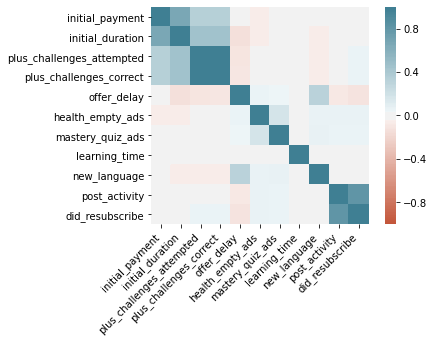

In [6]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

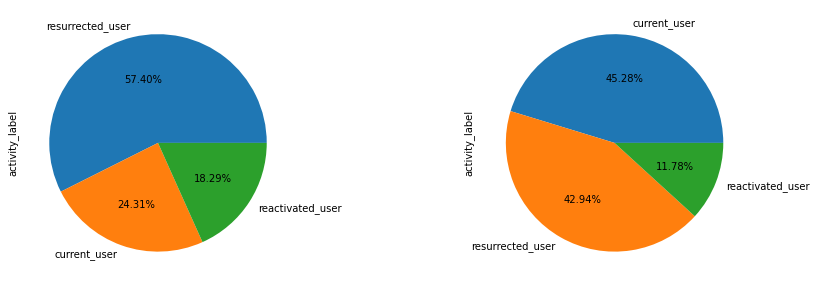

In [8]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
df[df['did_resubscribe']==1]['activity_label'].value_counts().plot.pie(autopct='%.2f%%',ax=axes[1]);
df['activity_label'].value_counts().plot.pie(autopct='%.2f%%',ax=axes[0]);

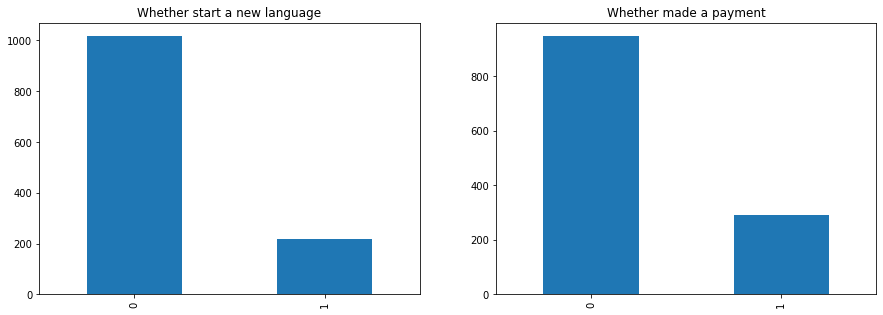

In [33]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
df[df['did_resubscribe']==1]['new_language'].value_counts().plot(kind='bar',ax=axes[0]);
df[df['did_resubscribe']==1]['initial_payment'].value_counts().plot(kind='bar',ax=axes[1]);
axes[0].set_title("Whether start a new language");
axes[1].set_title("Whether made a payment");

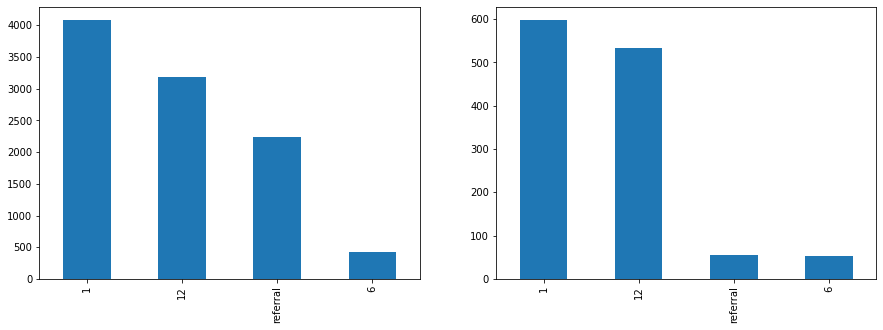

In [10]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
df['initial_tier'].value_counts().plot(kind='bar',ax=axes[0]);
df[df['did_resubscribe']==1]['initial_tier'].value_counts().plot(kind='bar',ax=axes[1]);

In [11]:
# Handle categorical features by one-hot encoding
n_columns = ["initial_tier", "activity_label"] 
dummy_df = pd.get_dummies(df[n_columns])
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(n_columns, axis=1)

In [12]:
X, y = df.drop(['did_resubscribe'],axis=1), df['did_resubscribe']
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('number of records：{}; positive ratio {:.2%}; nagative ratio {:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))

number of records：9930; positive ratio 87.52%; nagative ratio 12.48%


## Predict resubscription

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X, y = df.drop(['did_resubscribe','post_activity'],axis=1), df['did_resubscribe']
df_col = list(X.columns)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
from imblearn.over_sampling import SMOTE
# handle imbalanced data
sm = SMOTE(random_state=42)    # over-sampling
X_train, y_train = sm.fit_sample(X_train, y_train)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV

rf_classifier = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 150],
              'min_samples_split':[2,4,6],
              'max_depth': [5, 10, 15]}

grid_obj = GridSearchCV(rf_classifier,
                        param_grid=param_grid,
                        scoring='recall',
                        cv=5)

grid_fit = grid_obj.fit(X_train, y_train)
rf = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

best params: RandomForestClassifier(max_depth=15, n_estimators=150)
best params: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}
best score: 0.918018664752333


In [27]:
rf.fit(X_train, y_train) # fit optimised model to the training data
probs = rf.predict_proba(X_test) # predict probabilities
probs = probs[:, 1]
rf_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
rf_recall = recall_score(y_test, rf.predict(X_test))
rf_f1 = f1_score(y_test, rf.predict(X_test))
print('AUC score: %.3f' % rf_roc_auc)
print('Recall Score: %.3f' % rf_recall)
print('F1 Score: %.3f' % rf_f1)
print(classification_report(y_test, rf.predict(X_test)))

AUC score: 0.802
Recall Score: 0.550
F1 Score: 0.426
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1726
           1       0.35      0.55      0.43       260

    accuracy                           0.81      1986
   macro avg       0.64      0.70      0.65      1986
weighted avg       0.85      0.81      0.82      1986



Accuracy of Random Forest Classifier on test set: 80.56%


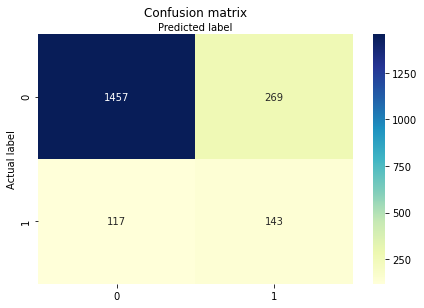

In [28]:
cnf_matrix = metrics.confusion_matrix(y_test, rf.predict(X_test))
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu",fmt="d")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label');
print('Accuracy of Random Forest Classifier on test set: {:.2f}%'.format(rf.score(X_test, y_test)*100))

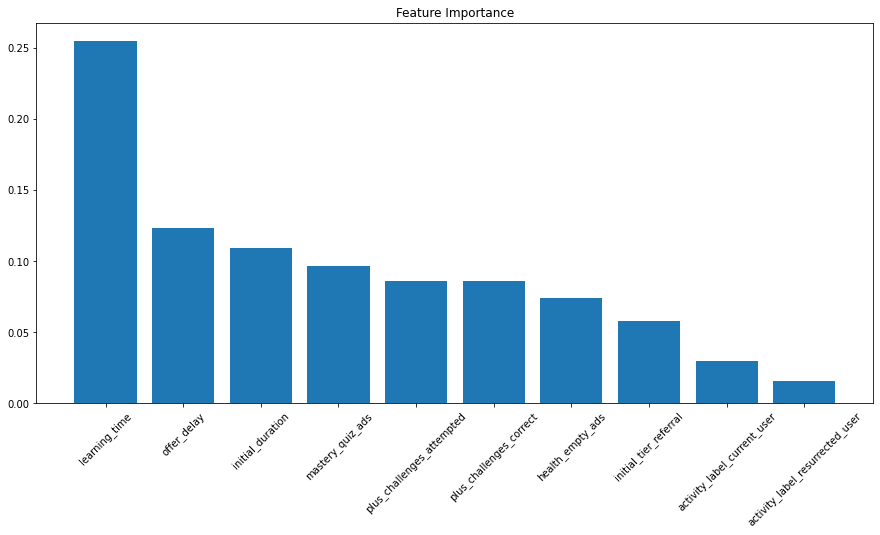

In [39]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10] # Sort feature importances in descending order and choose top 10
names = [df_col[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7))
plt.title("Feature Importance")
plt.bar(range(10), importances[indices])
plt.xticks(range(10), names, rotation=45)
plt.show()

In [59]:
# Check relationship between target and features
d = pd.DataFrame(X_test,columns=df_col)
d['probs']=probs
d.corr()['probs']

initial_payment                   -0.019476
initial_duration                  -0.036912
plus_challenges_attempted          0.068995
plus_challenges_correct            0.068493
offer_delay                       -0.113669
health_empty_ads                   0.141707
mastery_quiz_ads                   0.101305
learning_time                      0.052395
new_language                      -0.000467
initial_tier_1                     0.171402
initial_tier_12                    0.175688
initial_tier_6                    -0.011067
initial_tier_referral             -0.391011
activity_label_current_user        0.304800
activity_label_reactivated_user   -0.180630
activity_label_resurrected_user   -0.129388
probs                              1.000000
Name: probs, dtype: float64